<H1> Introduction </H1>

[ProtoRL](https://www.github.com/philtabor/protorl/) is intended to be a lightweight framework (constructed on top of PyTorch) to enable rapid deployment of reinforcement learning agents. It's intended for use by hobbyists on high end desktop hardware - i.e. there is no optimization for deploying on cloud infrastructure.

Agents use an actor-learner architecture to leverage highly multithreaded workstations. Actors collect data and feed it to a centralized replay buffer, which is sampled by the learner to update the neural networks. Network parameters are periodically (every time step, by default) downloaded to the actors. Actors have policies that map environment observations to an action; there are a broad variety to choose from.

Out of the box, ProtoRL supports Deep Q Learning (dueling and double learning), DDPG, TD3, SAC, and PPO, with more to come in the near future.

<H2> Environments </H2>
The base installation supports the traditional reinforcement learning environments, as well as the Atari library.

Environments are instantiated with the make_env function, that takes a variety of optional inputs.
 * use_atari: (bool) required to apply wrappers for downsampling, gray scaling, & frame stacking. False by default.
 * shape: (tuple) shape of downsampled frames if use_atari is true. (84, 84, 1) by default.
 * repeat: (int) number of frames to repeat an action. 4 by default.
 * clip_rewards: (bool) clip rewards to +/- 1.0. False by default.
 * no_ops: (int) number of operations to do nothing. 0 by default.
 * fire_first: (bool) if True the agent's first action of the episode is to fire. False by default.
 * n_threads: (int) Number of environments to spool up; each gets a thread. 1 by default.


In [1]:
from protorl.wrappers.common import make_env

env_name = 'CartPole-v1'
env = make_env(env_name)

<H2> Networks </H2>
The network architectures are generally divided up into bases and heads. The base layer interfaces with the environment, and there are a number of options depending on the type of environment. Names are required for checkpointing purposes.

* CriticBase: concatenates states and actions before feed forward. Relu activations on 2 hidden layers.
* LinearBase: Takes observation as input and passes through 2 hidden layers. Relu activations.
* AtariBase: 3 layer conv network with relu activations.
* LinearTanhBase: Takes observation as input and passes through 2 hidden layers. Tanh activations.

Network heads take the inputs from the base layers and output whatever is required.
* QHead: outputs the Q values for each action. 1 hidden layer with a relu activation and unactivated output layer.
* DuelingHead: outputs both the value and advantage streams for dueling Q learning.
* DeterministicHead: outputs a deterministic continuous action with a tanh activation (for ddpg, td3).
* MeanAndSigmaHead: outputs a mu and sigma for use in a continuous gaussian distribution.
* ValueHead: outputs a single value, intended to represent the value of a state.
* SoftmaxHead: outputs a softmax probability distribution.
* BetaHead: Outputs an alpha and a beta for use in a beta probability distribution (for PPO).

In [2]:
from protorl.networks.base import LinearBase
from protorl.networks.head import QHead
from torch.nn import Sequential

input_dims = env.observation_space.shape
hidden_layers = [512]

# network will have dims [(*input_dims, 256), (256, 512), (512, n_actions)]
base = LinearBase(input_dims=input_dims, name='q_base')
head = QHead(n_actions=env.action_space.n,
             hidden_layers=hidden_layers,
             name='q_head')
q_online = Sequential(base, head)

t_base = LinearBase(input_dims=input_dims, name='q_target_base')
t_head = QHead(n_actions=env.action_space.n,
               hidden_layers=hidden_layers,
               name='q_target_head')
q_target = Sequential(t_base, t_head)

<H2> Policies </H2>
Policies are distinct from actors and agents. This lets actors that live on different threads have different hyperparameters (i.e. each dqn actor could have separate epsilon value.

* BetaPolicy: uses a Beta distribution for sampling probabilistic actions. Can return entropy as well as actions and log probs. If you pass in an old_action, it lets you calculate the log probs. For use in PPO.
* DiscretePolicy: uses a categorical distribution to sample discrete actions. Can also calculate entropy. For use in PPO.
* EpsilonGreedyPolicy: selects a random action some of the time, else selects the max action. For use in DQN.
* GaussianPolicy: samples a normal distribution for a continuous action. Can also calculate entropy. For use in PPO.
* NoisyDeterministicPolicy: calculates a random noise to add to the output of a deterministic network. For TD3/DDPG.

In [3]:
from protorl.policies.epsilon_greedy import EpsilonGreedyPolicy
policy = EpsilonGreedyPolicy(n_actions=env.action_space.n, eps_dec=1e-4)

<H2> Agents </H2>
Each agent is comprised of one or more actors and a learner. The actors interact with an environment and generate samples to feed to the centralized replay buffer. The learner samples this data to perform gradient descent on the neural networks. Prioritization is included in ProtoRL and is toggled with a boolean flag.

In [4]:
from protorl.agents.dqn import DQNAgent as Agent
from protorl.actor.dqn import DQNActor as Actor
from protorl.learner.dqn import DQNLearner as Learner

dqn_actor = Actor(q_online, q_target, policy)
dqn_learner = Learner(q_online, q_target, prioritized=False, lr=1e-4)
agent = Agent(dqn_actor, dqn_learner)

<H2> Memory </H2>

Memory can be a bit tricky. In general, we will always want to save the states encountered, rewards, actions taken, and terminal flags. But that may not be enough. For PPO, for instance, we're going to need to store the log probs of the actions taken, according to the policy at the time. In the code base, I call each of these quantities of interest a field.

Memory is handled by a single class that can take any number of fields. It's completely generic in that sense, but it does have strong defaults. It defaults to state, action, reward, new state, terminal flag, with appropriate data types for each of these fields.

The memory object is instantiated through the use of an initialization function. The initialize memory function handles the basic type of memory we'll most often want, where we only have to supply the required information. Required arguments are: 
* obs_shape: list
* n_actions: int
* max_size: int
* batch_size: int.

The action space variable (optional, defaults to 'discrete') is there to account for the fact that we have a single memory class that can work for discrete and continuous action spaces. 

Prioritization is handled through the sum-tree data structure (e.g. proportional sampling) and is controlled through two hyperparameters. Alpha denotes the degree of prioritization; 0 is uniform 1 is fully prioritized. Beta controls the degree of importance sampling for the weights of the neural network. 0 is no weighting and 1 is fully weighted. 

Sampling can be one of a few different options, and it is not a property of the memory class itself. I made this choice because in PPO we want two different sampling modes: all of the memories (to calculate advantages) and the batches of random memories. Modes are: uniform, batch, all, prioritized. Hindsight experience is not included at this time.

If you're curous how it works, I'd encourage you to check out the [source code](https://github.com/philtabor/ProtoRL/blob/master/protorl/memory/generic.py).

In [5]:
from protorl.memory.generic import initialize_memory

memory = initialize_memory(max_size=100_000,
                           obs_shape=env.observation_space.shape,
                           batch_size=64,
                           n_actions=env.action_space.n,
                           action_space='discrete',
                           prioritized=False,
                           # if you want to set prioritized to True, you'll want to specify alpha and beta.
                           # alpha=0.6,
                           # beta=0.3,
                          )

<H2> Episode Loops </H2>
All of the interaction between the agent and the environment is handled in the episode loop.

This means the episode loop object gets the environment, agent, memory object and how we want to sample memories. Options include:

* single: handles a single environment instance. For use with DQN, DDPG, SAC, TD3
* ppo_episode: handles a multithreaded environment. For use with PPO.

The sample mode is included because the episode loop handles getting data from the replay buffer to feed to the agent.

In [6]:
from protorl.loops.single import EpisodeLoop

sample_mode = 'uniform'  # if using prioritization, set this to 'prioritized'
ep_loop = EpisodeLoop(agent, env, memory, sample_mode=sample_mode)

Models are saved automatically, so we have to make sure the model directory exists.

Please note that this is only for model evaluation. I don't have a proper implementation for saving models during training, with the intention of resuming training later. This isn't technically difficult in itself, but the way I have designed the framework makes passing around the required information cumbersome.

In [7]:
import os
if not os.path.exists('models'):
    os.makedirs('models')

Now all we have to do is play the games!

In [8]:
scores, steps_array = ep_loop.run(300)

episode 0 ep score 23.0 average score 23.0 n steps 23
episode 1 ep score 14.0 average score 18.5 n steps 37
episode 2 ep score 11.0 average score 16.0 n steps 48
episode 3 ep score 13.0 average score 15.2 n steps 61
episode 4 ep score 33.0 average score 18.8 n steps 94
episode 5 ep score 34.0 average score 21.3 n steps 128
episode 6 ep score 21.0 average score 21.3 n steps 149
episode 7 ep score 28.0 average score 22.1 n steps 177
episode 8 ep score 12.0 average score 21.0 n steps 189
episode 9 ep score 30.0 average score 21.9 n steps 219
episode 10 ep score 43.0 average score 23.8 n steps 262
episode 11 ep score 12.0 average score 22.8 n steps 274
episode 12 ep score 13.0 average score 22.1 n steps 287
episode 13 ep score 26.0 average score 22.4 n steps 313
episode 14 ep score 37.0 average score 23.3 n steps 350
episode 15 ep score 20.0 average score 23.1 n steps 370
episode 16 ep score 17.0 average score 22.8 n steps 387
episode 17 ep score 36.0 average score 23.5 n steps 423
episode

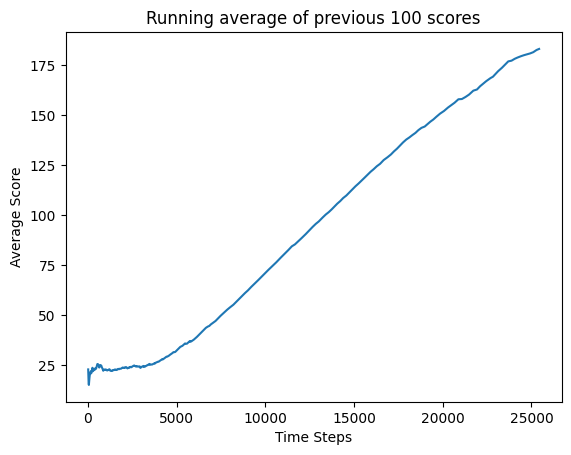

In [9]:
from protorl.utils.common import plot_learning_curve

plot_learning_curve(steps_array, scores)